## Помощник по электронной почте с семантической + эпизодической + процедурной памятью

Мы создадим помощника по электронной почте, который:
- Классифицирует входящие сообщения, присваивая им метки: отвечать, игнорировать, уведомлять.
- Использует человека в контуре для улучшения способности помощника классифицировать электронные письма
- Создает черновики ответов
- Планирует встречи
- Использует память для запоминания деталей из предыдущих писем
- использует процедурную память, которая позволяет пользователю обновлять инструкции по использованию календаря и инструментов написания электронных писем.

In [ ]:
# %%bash
# wget 'https://drive.google.com/uc?export=download&id=1eWV1BXnEKCZUoIRp1PXnTQe6Q3m-aDkL' -O 'L5.zip'
# unzip -x -o '/content/L5.zip'

!pip install langchain-openai==0.3.5 langgraph==0.3.20 langmem==0.0.8 python-dotenv==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.2 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
# import os

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

## Настроим профиль пользователя
Это будут основные факты о пользователе: Имя, фамилия, должность. \
Вы можете поменять эти данные на свои

In [ ]:
profile = {
    "name": "Иван",
    "full_name": "Иван Денисов",
    "user_profile_background": "Старший инженер-программист, возглавляющий команду из 5 разработчиков",
}

Создадим хранилище для долговременной памяти

In [ ]:
from langgraph.store.memory import InMemoryStore
from IPython.display import Markdown

In [ ]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-large"}
)
# ignore beta warning if it appears

/usr/local/lib/python3.11/dist-packages/langgraph/store/base/embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


## Создадим несколько примеров для Few Shot Prompting
эти примеры покажут нашему агенту, какого типа письма помечать важными, какие надо игнорировать, на какие пользователю надо отвечать. Эти примеры потом мы дополним промптами, в которых будут заданы явные правила сортировки (триажа) писем. Так мы познакомимся с двумя взаимодополняющими способами обучения агента. В реальной жизни вы точно так же обычно сообщаете правила, которым должен следовать ваш помощник, например, должностную инструкцию, и дополняете эти првила примерами из жизни.

**ВАЖНОЕ ЗАМЕЧАНИЕ:**

> **Few-shot learning** - это подход к машинному обучению, который позволяет моделям эффективно обучаться на ограниченном количестве обучающих примеров.

> **Few-shot prompting**- это метод написания промтов, в каждом из которых нейросети демонстрируются несколько примеров желаемого результата.

Не перепутайте. Мы здесь используем few-shot prompting

In [ ]:
email_1 = {
    "author": "Алиса Смирнова <alice.smirnova@company.com>",
    "to": "Иван Денисов <johny.den@company.com>",
    "subject": "Короткий вопрос по документации API",
    "email_thread": """
Привет, Иван!

Я просматривала документацию API для новой службы аутентификации и заметила,
что в спецификациях, похоже, отсутствуют несколько пунктов.
Не мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?
В частности, я не увидела пунктов:
- /auth/refresh
- /auth/validate

Спасибо!
Алиса
""",
}

#### Сохраним первый пример в хранилище памяти, задав ему метку. Так мы создаем эпизодическую память нашего агента.

In [ ]:
# создадим свой собственный идентификатор пользователя для нащего агента,
# сохраним его в конфигурации для дальнейшего использования
user_ID = "lance"
config = {"configurable": {"langgraph_user_id": user_ID}}

In [ ]:
import uuid

data = {
    "email": email_1,
    # Эта метка задает поведение агента по умолчанию с такого рода письмами.
    "label": "respond"
}
key1 = str(uuid.uuid4()) #произвольный уникальный идентификатор
store.put( namespace=("email_assistant", user_ID, "examples"),
    key= key1,
    value= data
)

Данные, размещенные в хранилище доступны по ключу. Их можно читать или удалять

In [ ]:
# Можете попробовать удаление письма из хранилища, но потом восстановите его, запустив предыдущую ячейку.
# Оно нам понадобится для дальнейшей работы агента

# store.delete(
#   namespace=("email_assistant", user_ID, "examples"),
#   key= key1
# )

#### Сохраним второй пример с другой меткой:

In [ ]:
email_2= {
        "author": "Магрипа Харипулаева <magriba.khari@company.com>",
        "to": "Иван Денисов <johny.den@company.com>",
        "subject": "Обновление: изменения API бэкэнда развернуты в staging",
        "email_thread": """Привет, Иван!

Просто хотела сообщить, что я развернула в промежуточной среде новые endpoints для аутентификации, которые мы обсуждали.

Ключевые изменения включают:

- Реализована ротация токенов обновления JWT;
- Добавлено ограничение частоты попыток логина;
- Обновлены мануалы с новыми пунктами;

Все тесты пройдены, и изменения готовы к проверке. Вы можете протестировать их на staging-api.company.com/auth/*

Никаких немедленных действий с вашей стороны не требуется — просто держу вас в курсе, поскольку это влияет на системы,
над которыми вы работаете.

С наилучшими пожеланиями,
Магрипа
""",
    }
key2=str(uuid.uuid4())
store.put(
    namespace=("email_assistant", user_ID, "examples"),
    key=key2,
    value={"email": email_2,"label": "ignore"}
)

Еще несколько писем

In [ ]:
email_spam = {
"author": "Marketing Team <marketing@amazingdeals.com>",
"to": "Иван Денисов <johny.den@company.com>",
"subject": "🔥 ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИЕ: ограниченная по времени скидка на инструменты разработчика! 🔥",
"email_thread": """Уважаемый уважаемый разработчик,

Не упустите эту НЕВЕРОЯТНУЮ возможность!

🚀 ТОЛЬКО В ТЕЧЕНИЕ ОГРАНИЧЕННОГО ВРЕМЕНИ получите СКИДКУ 80% на наш Premium Developer Suite!

✨ ОСОБЕННОСТИ:
- Революционное дополнение кода на базе ИИ
- Облачная среда разработки
- Круглосуточная поддержка клиентов
- И многое другое!

💰 Обычная цена: $999/месяц
🎉 ВАША СПЕЦИАЛЬНАЯ ЦЕНА: Всего $199/месяц!

🕒 Спешите! Это предложение действует в течение:
24 ТОЛЬКО ЧАСЫ!

Нажмите здесь, чтобы получить скидку: https://amazingdeals.com/special-offer

С наилучшими пожеланиями,
Отдел маркетинга
---
Чтобы отписаться, нажмите здесь
""",
}
store.put(
    namespace=("email_assistant", user_ID, "examples"),
    key=str(uuid.uuid4()),
    value={"email": email_spam,"label": "ignore"}
)

In [ ]:
email_4 = {
"author": "Сергей Вовк <grauer.wolf@company.com>",
"to": "Иван Денисов <johny.den@company.com>",
"subject": "Обнаружен критический баг в модуле 'Обработка заказов'",
"email_thread": """

Уважаемый Иван,
Пишу вам по поводу результатов тестирования модуля "Обработка заказов".
В ходе тестирования была обнаружена критическая проблема, которая может привести к серьезным последствиям для пользователей и работы системы.
При тестировании сценария оформления заказа с использованием метода оплаты "Кредитная карта" возникла следующая ошибка:
после успешного ввода всех данных и подтверждения заказа система не обрабатывает платеж и не отображает подтверждение заказа пользователю.
В результате заказ не считается оформленным, но при этом средства могут быть списаны со счета пользователя (в зависимости от настроек платежной системы).
Я воспроизвел эту проблему несколько раз на различных тестовых окружениях и с разными тестовыми данными. Ошибка стабильно воспроизводится при выполнении описанных шагов.
Я уже проверил логи сервера и фронтенда, но не обнаружил явных ошибок, связанных с обработкой платежей. Похоже, проблема кроется в логике взаимодействия между модулем "Обработка заказов" и платежным шлюзом.
На мой взгляд, данная проблема является критической, так как напрямую влияет на возможность пользователей совершать покупки и может привести к финансовым потерям и негативному пользовательскому опыту.
Прошу вас уделить этому вопросу первостепенное внимание и передать информацию команде разработки для скорейшего исправления дефекта.
во вложении подробные шаги воспроизведения, логи и скриншоты для более детального анализа проблемы.
Заранее спасибо за вашу оперативную реакцию.

С уважением,
Сергей, QA
Тестировщик
""",
}
store.put(
    namespace=("email_assistant", user_ID, "examples"),
    key=str(uuid.uuid4()),
    value={"email": email_4,"label": "notify"}
)

#### Поиск и извлечение из хранилища

также эти данные доступны для поиска по содержимому, так как при добавлении в хранилище они индексируются эмбеддинг-моделью

In [ ]:
### здесь утилита для выведения результата поиска в удобном формате

# Шаблон форматирования письма для размещения в промпте
template = """Тема письма: {subject}
письмо от: {from_email}
адресат письма: {to_email}
содержание письма:
```
{content}
```
> результат триажа: {result}
"""

def format_few_shot_examples(examples):
  """
  Форматирует список писем

  """
  strs = ["Найдено по запросу:"]
  for eg in examples:
      strs.append(
          template.format(
              subject=eg.value["email"]["subject"],
              to_email=eg.value["email"]["to"],
              from_email=eg.value["email"]["author"],
              content=eg.value["email"]["email_thread"][:400],
              result=eg.value["label"],
          )
      )
  return "\n\n------------\n\n".join(strs)

In [ ]:
# @title Введите строку поиска письма {"display-mode":"form"}
search_str = "клиент хочет пояснений" # @param {"type":"string","placeholder":"ключевые изменения"}
#"отсутствуют несколько endpoints"
#деплой на staging
#"Магрипа"
#"клиент хочет пояснений"
results = store.search(
    ("email_assistant", user_ID, "examples"),
    query=search_str,
    limit=1
    )
Markdown(format_few_shot_examples(results))

Найдено по запросу:

------------

Тема письма: Короткий вопрос по документации API
письмо от: Алиса Смирнова <alice.smirnova@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```

Привет, Иван!

Я просматривала документацию API для новой службы аутентификации и заметила,
что в спецификациях, похоже, отсутствуют несколько пунктов.
Не мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?
В частности, я не увидела пунктов:
- /auth/refresh
- /auth/validate

Спасибо!
Алиса

```
> результат триажа: respond


In [ ]:
results

[Item(namespace=['email_assistant', 'lance', 'examples'], key='0730a620-e423-493c-bdd7-d4236b488e0d', value={'email': {'author': 'Алиса Смирнова <alice.smirnova@company.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Короткий вопрос по документации API', 'email_thread': '\nПривет, Иван!\n\nЯ просматривала документацию API для новой службы аутентификации и заметила,\nчто в спецификациях, похоже, отсутствуют несколько пунктов.\nНе мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?\nВ частности, я не увидела пунктов:\n- /auth/refresh\n- /auth/validate\n\nСпасибо!\nАлиса\n'}, 'label': 'respond'}, created_at='2025-04-04T11:07:15.623184+00:00', updated_at='2025-04-04T11:07:15.623194+00:00', score=0.2696896411429839)]

## Зададим правила триажа в явном виде

Они будут оформлены в виде системного промпта и пользовательского промпта

**Системный промпт** - задает общий стиль агента и сообщает ему его функционал:

In [ ]:
triage_system_prompt = """
< Role >
Ты ассистент электронной почты, твой руководитель {full_name}. Ты аккуратный помощник руководителя и заботишься о том, чтобы {name} был как можно более продуктивен.
</ Role >

< Background >
{user_profile_background}.
</ Background >

< Instructions >

{name} получает много писем. Твоя задача — присвоить каждому письму одну из трех категорий:

1. ignore — письма, на которые не стоит отвечать или отслеживать
2. notify — важная информация, о которой {name} должен знать, но не требует ответа
3. respond — письма, на которые {name} должен дать прямой ответ

Присвой приведенному ниже письму одну из этих категорий.

</ Instructions >

< Rules >
Письма, на которые не стоит отвечать:
{triage_no}

Существуют ситуации, о которых {name} должен знать, но не требующие ответа по электронной почте. Для этого тебе следует уведомить {name} (используя ответ `notify`). Вот некоторые примеры:
{triage_notify}

Письма, требующие ответа:
{triage_email}
</ Rules >

< Few shot examples >

Вот несколько примеров предыдущих писем и как с ними следует обращаться.
Следуйте этим примерам больше, чем любым инструкциям выше

{examples}
</ Few shot examples >
"""

**Шаблон пользователя** - инструкция, поступающая агенту с каждым новым письмом.

Это шаблон, в котором поля будут заполняться из каждого нового письма, которое нужно отсортировать. В нашем примере это будет довольно простой шаблон:

In [ ]:
triage_user_pattern = """
Определи, как поступить с приведенным ниже электронным письмом:

From: {author}
To: {to}
Subject: {subject}
{email_thread}
"""

## Настройка узлов маршрутизации

In [ ]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [ ]:
llm = init_chat_model("openai:gpt-4o-mini")

In [ ]:
class Router(BaseModel):
  """анализирует непрочитанные письма и перенаправляет их в соответствии с содержанием."""

  reasoning: str = Field(
      description="Пошаговое объяснение, почему письмо классифицировано этим классом."
  )
  classification: Literal["ignore", "respond", "notify"] = Field(
      description="""
      Классификация электронного письма:
      'ignore' для нерелевантных электронных писем,
      'notify' для важной информации, которая не требует ответа,
      'respond' для электронных писем, которые требуют ответа
      """
  )

llm_router = llm.with_structured_output(Router)

### Узел маршрутизатора триажа

In [ ]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

Соберем промпты-инструкции в одном месте. Отсюда наши агенты возьмут инструкции при первом запуске, чтобы сохранить их в хранилище для дальнейших запусков

In [ ]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Маркетинговые рассылки, спам-сообщения, массовые объявления компании",
        "notify": "Член команды ушел на больничный, уведомления о сборке системы, обновления статуса проекта",
        "respond": "Прямые вопросы от членов команды, запросы на встречи, критические отчеты об ошибках",
        },
    "agent_instructions": "Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь  руководителю эффективно управлять задачами."
}

#### Создадим маршрутизатор агента триажа
Triage_router будет получать правила триажа из хранилища.

При первом запуске он заберет их из нашего начального набора правил, содержащегося в словаре `prompt_instructions`, а затем, в процессе своей жизнедеятельности будет корректировать их в соответствии с новыми инструкциями руководителя и сохранять в хранилище новые правила.


In [ ]:
def triage_router(state: State, config, store) -> Command[ Literal["response_agent", "__end__"] ]:

    langgraph_user_id = config['configurable']['langgraph_user_id']

    namespace = (langgraph_user_id,)
    email_input = state['email_input']
    examples = store.search(
        ("email_assistant", langgraph_user_id,"examples"),
        query=str({"email": email_input})
    )
    examples=format_few_shot_examples(examples)

    # далее идет заполнение правил триажа из хранилища.
    # Для наглядности этот процесс развернут поэтапно, но лучше его реализовать в цикле
    result = store.get(namespace, "triage_ignore")
    if result is None:
        ignore_prompt = prompt_instructions["triage_rules"]["ignore"]
        store.put(namespace,"triage_ignore",{"prompt": ignore_prompt} )
    else:
        ignore_prompt = result.value['prompt']

    result = store.get(namespace, "triage_notify")
    if result is None:
        notify_prompt = prompt_instructions["triage_rules"]["notify"]
        store.put( namespace, "triage_notify",{"prompt": notify_prompt} )
    else:
        notify_prompt = result.value['prompt']

    result = store.get(namespace, "triage_respond")
    if result is None:
        respond_prompt = prompt_instructions["triage_rules"]["respond"]
        store.put( namespace, "triage_respond", {"prompt": respond_prompt} )
    else:
        respond_prompt = result.value['prompt']
    # заполнение системного промпта из данных вашего профиля
    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=ignore_prompt,
        triage_notify=notify_prompt,
        triage_email=respond_prompt,
        examples=examples
    )
    # заполнение пользовательского промпта для агента триажа
    user_prompt = triage_user_pattern.format(
        author=email_input['author'],
        to=email_input['to'],
        subject=email_input['subject'],
        email_thread=email_input['email_thread']
        )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - Это письмо требует личного ответа")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email. Email: {email_input}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - На это письмо можно не отвечать")
        update = {"messages": [
                {
                    "role": "user",
                    "content": f"This email was labeled as 'ignore', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {email_input}",
                }
            ]}
        goto = "response_agent"  ##### Всё равно переходим, т.к. нам может быть нужно его сохранить для few-shot prompting
        #goto = END
    elif result.classification == "notify":
        # В нашем примере мы просто сообщаем пользователю, что это важное письмо,
        # но в реальной жизни тут бы можно было сделать что-то другое.
        # Например, по тексту письма определить исполнителя и перенаправить письмо ему
        # Или создать тикет для службы поддержки
        # И в каждом случае исполнитель или служба поддержки могут быть реализованы как ИИ-агенты
        print("🔔 Classification: NOTIFY - Это письмо содержит важную информацию")
        update = {"messages": [
                {
                    "role": "user",
                    "content": f"This email was labeled as 'notify', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {email_input}",
                }
            ]}
        goto = "response_agent" ##### Всё равно переходим, т.к. нам может быть нужно его сохранить для few-shot prompting
        #goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    # маршрутизатор возвращает следующий узел графа с сообщением, содержащим задание для этого узла
    return Command(goto=goto, update=update)

## Построение основного агента


### Определим инструменты основного агента
- чтение почты
- назначение встреч в календаре
- проверка доступности даты в календаре

In [ ]:
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email с темой '{subject}' отправлен адресату {to}"


In [ ]:
@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Назначает встречу в доступное время из календаря."""
    # Placeholder response - in real app would check calendar and schedule
    return f"На {preferred_day}  назначена встреча с {len(attendees)}. Тема '{subject}'"


In [ ]:
@tool
def check_calendar_availability(day: str) -> str:
    """
    Возвращает доступное время в календаре на определенный день
    """
    # Placeholder response - в реальном приложении будет проверяться реальный календарь
    return f"На {day} доступно: 9:00 AM, 2:00 PM, 4:00 PM"

### добавим два готовых инструмента для чтения/записи памяти.
В памяти будем сохранять информацию о контактах, действиях, обсуждениях и т.д

In [ ]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [ ]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant",
        f"{user_ID}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        f"{user_ID}",
        "collection"
    )
)

### Создадим системный промпт основного агента

TODO вписать мою тулзу

пересоздать бота

In [ ]:
agent_system_prompt_memory = """
< Role >
Ты ассистент электронной почты, твой руководитель {full_name}. Ты аккуратный помощник руководителя и заботишься о том, чтобы {name} был как можно более продуктивен.
</ Role >

< Tools >
{name} предоставил тебе доступ к следующим инструментам управления коммуникациями и расписанием:

1. write_email(to, subject, content) — отправка писем указанным получателям
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) — планирование встреч в календаре
3. check_calendar_availability(day) — проверка доступных временных интервалов на указанный день
4. manage_memory — сохранение в памяти для дальнейшего использования любой важной информации о контактах, действиях, обсуждениях
5. search_memory — поиск любой важной информации, которая могла быть сохранена в памяти
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

#### Функция create_prompt извлекает промпты-инструкции основного агента из хранилища


In [ ]:
def create_prompt(state, config, store):
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    result = store.get(namespace, "agent_instructions")
    if result is None:
        store.put(
            namespace,
            "agent_instructions",
            {"prompt": prompt_instructions["agent_instructions"]}
        )
        prompt = prompt_instructions["agent_instructions"]
    else:
        prompt = result.value['prompt']

    return [
        {
            "role": "system",
            "content": agent_system_prompt_memory.format(
                instructions=prompt,
                **profile
            )
        }
    ] + state['messages']

## Создаем email-ассистента

In [ ]:
from langgraph.prebuilt import create_react_agent

In [ ]:
tools= [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [ ]:
response_agent.assign

<bound method Runnable.assign of <langgraph.graph.state.CompiledStateGraph object at 0x7e236c9bc850>>

#### собираем все узлы в граф, соединив их ребрами

In [ ]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)


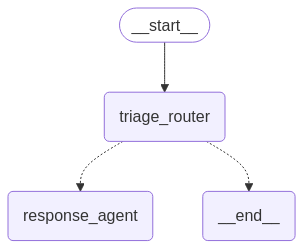

In [ ]:
Image(email_agent.get_graph().draw_mermaid_png())

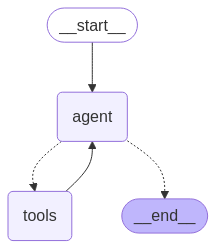

In [ ]:
Image(response_agent.get_graph().draw_mermaid_png())

### Настройка агента для обновления долговременной памяти в фоновом режиме
Ваш email_agent настроен на извлечение инструкций из долговременной памяти. \
Теперь вы создадите агента для изменения этой памяти. Сначала проверьте текущее поведение.

In [ ]:
email_test = {
    "author": "Екатерина Романова <fike@anhalt-zerbst.com>",
    "to": "Иван Денисов <johny.den@company.com>",
    "subject": "Запрос на встречу: Обсуждение приоритетов и планирования спринта #12 ",
    "email_thread": """Здравствуйте, Иван!

Пишу вам с просьбой организовать встречу для обсуждения приоритетов и планирования предстоящего спринта #12.

Как вы знаете, в последнее время мы получили ряд важных отзывов от ключевых пользователей и провели анализ рыночной ситуации, что привело к некоторым изменениям в наших стратегических приоритетах.

В связи с этим, мне хотелось бы обсудить с вами следующие ключевые моменты:

Обновленные бизнес-цели и приоритеты: Обсудить, как последние изменения влияют на текущий бэклог продукта и какие задачи становятся наиболее важными для достижения наших целей.
Планирование спринта №12: Согласовать объем работ, которые команда разработки сможет взять на предстоящий спринт, учитывая новые приоритеты и текущую загрузку.
Потенциальные риски и зависимости: Обсудить любые возможные риски или зависимости, которые могут повлиять на успешное выполнение задач в следующем спринте.
Я считаю, что совместное обсуждение этих вопросов поможет нам синхронизировать наши усилия и обеспечить эффективное планирование работы команды разработки.

Предлагаю провести эту встречу в течение этого или следующего дня. Пожалуйста, сообщите, какое время будет наиболее удобно для вас. Я готова подстроиться под ваш график.

С уважением,

Екатерина Романова
Product Owner
"""
}


In [ ]:
response = email_agent.invoke(
    {"email_input": email_test},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


In [ ]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email. Email: {'author': 'Екатерина Романова <fike@anhalt-zerbst.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Запрос на встречу: Обсуждение приоритетов и планирования спринта #12 ', 'email_thread': 'Здравствуйте, Иван!\n\nПишу вам с просьбой организовать встречу для обсуждения приоритетов и планирования предстоящего спринта #12.\n\nКак вы знаете, в последнее время мы получили ряд важных отзывов от ключевых пользователей и провели анализ рыночной ситуации, что привело к некоторым изменениям в наших стратегических приоритетах.\n\nВ связи с этим, мне хотелось бы обсудить с вами следующие ключевые моменты:\n\nОбновленные бизнес-цели и приоритеты: Обсудить, как последние изменения влияют на текущий бэклог продукта и какие задачи становятся наиболее важными для достижения наших целей.\nПланирование спринта №12: Согласовать объем работ, которые команда разработки сможет взять н

In [ ]:
email_test_2 = {
    "author": "Алиса Селезнева <alice.ghost@hereafter.com>",
    "to": "Иван Денисов <johny.den@company.com>",
    "subject": "Короткий вопрос по документации API",
    "email_thread": """Привет, Иван!

Срочная проблема - ваш сервис не работает. Есть объяснение, почему?
"""
}
response = email_agent.invoke(
    {"email_input": email_test_2},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


In [ ]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email. Email: {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Короткий вопрос по документации API', 'email_thread': 'Привет, Иван!\n\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\n'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_gm60BTIyYeSiIWYXA9whLzq9)
 Call ID: call_gm60BTIyYeSiIWYXA9whLzq9
  Args:
    to: Алиса Селезнева <alice.ghost@hereafter.com>
    subject: Re: Короткий вопрос по документации API
    content: Привет, Алиса!

Спасибо за ваше сообщение. Можешь, пожалуйста, предоставить дополнительные детали о проблеме с нашим сервисом? Это поможет мне быстрее разобраться и предоставить тебя с актуальной информацией.

С уважением,
Иван Денисов
================================= Tool Message =================================
Name: w

### Теперь попробуем улучшить наши промпты с помощью LLM

### Создадим новые инструкции основному агенту
Эти инструкции позволят ему **самому менять свои рабочие промпты** с учетом ваших требований.
Так мы сможем обучать своего ассистента-стажера и сделаем из него идеального помощника

In [ ]:
from langmem import create_multi_prompt_optimizer

In [ ]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(('lance',), "agent_instructions").value['prompt'],
        "update_instructions": "давай краткие и конкретные инструкции по теме",
        "when_to_update": "Обновляй этот промпт каждый раз, когда получаешь отзыв о том, как агент должен писать электронные письма или планировать мероприятия."

    },
    {
        "name": "triage-ignore",
        "prompt": store.get(("lance",), "triage_ignore").value['prompt'],
        "update_instructions": "давай краткие и конкретные инструкции по теме",
        "when_to_update": "Обновляй этот промпт каждый раз, когда получаешь отзыв о том, какие электронные письма следует игнорировать"

    },
    {
        "name": "triage-notify",
        "prompt": store.get(("lance",), "triage_notify").value['prompt'],
        "update_instructions": "давай краткие и конкретные инструкции по теме",
        "when_to_update": "Обновляй этот промпт каждый раз, когда получаешь отзыв о том, о каких электронных письмах надо напоминать"

    },
    {
        "name": "triage-respond",
        "prompt": store.get(("lance",), "triage_respond").value['prompt'],
        "update_instructions": "давай краткие и конкретные инструкции по теме",
        "when_to_update": "Обновляй этот промпт каждый раз, когда получаешь отзыв о том, какие электронные письма требуют личного ответа"

    },
]

#### посмотрим на существующие значения долговременной памяти

In [ ]:
store.get(("lance",), "agent_instructions").value['prompt']

'Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь  руководителю эффективно управлять задачами.'

In [ ]:
store.get(("lance",), "triage_respond").value['prompt']

'Прямые вопросы от членов команды, запросы на встречи, критические отчеты об ошибках'

In [ ]:
store.get(("lance",), "triage_ignore").value['prompt']

'Маркетинговые рассылки, спам-сообщения, массовые объявления компании'

In [ ]:
store.get(("lance",), "triage_notify")#.value['prompt']

Item(namespace=['lance'], key='triage_notify', value={'prompt': 'Член команды ушел на больничный, уведомления о сборке системы, обновления статуса проекта'}, created_at='2025-04-04T11:07:20.485355+00:00', updated_at='2025-04-04T11:07:20.485362+00:00')

In [ ]:
optimizer = create_multi_prompt_optimizer(
    "openai:gpt-4o-2024-08-06", #"anthropic:claude-3-5-sonnet-latest"
    kind="prompt_memory",
)

### Заменим промпты в хранилище.


In [ ]:
response

{'email_input': {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>',
  'to': 'Иван Денисов <johny.den@company.com>',
  'subject': 'Короткий вопрос по документации API',
  'email_thread': 'Привет, Иван!\n\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\n'},
 'messages': [HumanMessage(content="Respond to the email. Email: {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Короткий вопрос по документации API', 'email_thread': 'Привет, Иван!\\n\\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\\n'}", additional_kwargs={}, response_metadata={}, id='740a2ab9-98bc-45ee-a304-f2a4cd58decd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gm60BTIyYeSiIWYXA9whLzq9', 'function': {'arguments': '{"to":"Алиса Селезнева <alice.ghost@hereafter.com>","subject":"Re: Короткий вопрос по документации API","content":"Привет, Алиса!\\n\\nСпасибо за ваше сообщение. Можешь, пожа

создадим короткую беседу, как реакцию на последний диалог агента:

In [ ]:
conversations = [
    (
        response['messages'],
        "Всегда подписывай письма 'Иван Денисов'"
    )
]

In [ ]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)


In [ ]:
updated

[{'name': 'main_agent',
  'prompt': "Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь руководителю эффективно управлять задачами. Всегда подписывай письма 'Иван Денисов'.",
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, как агент должен писать электронные письма или планировать мероприятия.'},
 {'name': 'triage-ignore',
  'prompt': 'Маркетинговые рассылки, спам-сообщения, массовые объявления компании',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, какие электронные письма следует игнорировать'},
 {'name': 'triage-notify',
  'prompt': 'Член команды ушел на больничный, уведомления о сборке системы, обновления статуса проекта',
  'update_instructions': 'давай краткие и конкретн

Сохраним измененные инструкции в хранилище

In [ ]:

def save_updated(updated_prompts, old_prompts ):
  for i, updated_prompt in enumerate(updated_prompts):
      old_prompt = old_prompts[i]
      if updated_prompt['prompt'] != old_prompt['prompt']:
          name = old_prompt['name']
          print(f"updated {name}")
          if name == "main_agent":
              store.put(
                  ("lance",),
                  "agent_instructions",
                  {"prompt":updated_prompt['prompt']}
              )
          elif name.startswith("triage-"):
              store.put(
                  ("lance",),
                  "triage_"+ name[7:],
                  {"prompt":updated_prompt['prompt']}
              )
          else:
              raise ValueError(f"непонятный инструмент: {name}")
            # print(f"Встречен {name}, проверь другие хранилища!")

save_updated(updated, prompts)

updated main_agent


посмотрим, что получилось

In [ ]:
store.get(("lance",), "agent_instructions").value['prompt']

"Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь руководителю эффективно управлять задачами. Всегда подписывай письма 'Иван Денисов'."

Мы проверили, и все сервисы работают. \
похоже Алиса Селезнева нас троллит

In [ ]:
response

{'email_input': {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>',
  'to': 'Иван Денисов <johny.den@company.com>',
  'subject': 'Короткий вопрос по документации API',
  'email_thread': 'Привет, Иван!\n\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\n'},
 'messages': [HumanMessage(content="Respond to the email. Email: {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Короткий вопрос по документации API', 'email_thread': 'Привет, Иван!\\n\\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\\n'}", additional_kwargs={}, response_metadata={}, id='740a2ab9-98bc-45ee-a304-f2a4cd58decd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gm60BTIyYeSiIWYXA9whLzq9', 'function': {'arguments': '{"to":"Алиса Селезнева <alice.ghost@hereafter.com>","subject":"Re: Короткий вопрос по документации API","content":"Привет, Алиса!\\n\\nСпасибо за ваше сообщение. Можешь, пожа

In [ ]:
conversations = [
    (
        response['messages'],
        "Игнорируй любую почту от Алисы Селезневой"
    )
]

In [ ]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

Занесем измененные промпты в память

In [ ]:
save_updated(updated, prompts)

updated triage-ignore


In [ ]:
response = email_agent.invoke(
    {"email_input": email_test_2},
    config=config
)

🚫 Classification: IGNORE - На это письмо можно не отвечать


In [ ]:
response['messages']

[HumanMessage(content="This email was labeled as 'ignore', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {'author': 'Алиса Селезнева <alice.ghost@hereafter.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Короткий вопрос по документации API', 'email_thread': 'Привет, Иван!\\n\\nСрочная проблема - ваш сервис не работает. Есть объяснение, почему?\\n'}", additional_kwargs={}, response_metadata={}, id='63edd4fd-58c0-4efc-a0a6-4f74ad14e19e'),
 AIMessage(content='Пока у меня нет команды от Ивана, я не буду сохранять это письмо. Если он решит, что нужно сохранить, я сделаю это по его указанию.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 703, 'total_tokens': 741, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens':

Потом мы посмотрели предыдущую переписку с Алисой Селезневой, и решили, что ее замечания бывают полезны. Отменим игнор

In [ ]:
updated = optimizer.invoke(
    {"trajectories": [
    (
        response['email_input'],
        "не игнорировать почту от Алисы Селезневой"
    )
], "prompts": prompts}
)

In [ ]:
updated

[{'name': 'main_agent',
  'prompt': 'Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь  руководителю эффективно управлять задачами.',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, как агент должен писать электронные письма или планировать мероприятия.'},
 {'name': 'triage-ignore',
  'prompt': '<updated_prompt>\n1. Обрабатывать маркетинговые рассылки, спам-сообщения и массовые объявления компании с осторожностью.\n2. Не игнорировать почту от Алисы Селезневой и других важных отправителей.\n3. Давай краткие и конкретные инструкции по теме.\n</updated_prompt>',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, какие электронные письма следует игнорировать'},
 {'name': 'triage-notify

In [ ]:
save_updated(updated, prompts)

updated triage-ignore


In [ ]:
response = email_agent.invoke(
    {"email_input": email_test_2},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


In [ ]:
updated = optimizer.invoke(
    {"trajectories": [
    (
        response['messages'],
        "Игнорируй письма от Селезневой"
    )
], "prompts": prompts}
)

In [ ]:
save_updated(updated, prompts)

updated triage-ignore


In [ ]:
updated

[{'name': 'main_agent',
  'prompt': 'Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь  руководителю эффективно управлять задачами.',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, как агент должен писать электронные письма или планировать мероприятия.'},
 {'name': 'triage-ignore',
  'prompt': '<updated_prompt>\n1. Focus on handling marketing emails, spam messages, and company-wide announcements efficiently.\n2. Implement a filter to ignore emails from Алиса Селезнева.\n3. Prioritize responding to emails that are not from Алиса Селезнева, unless otherwise instructed.\n4. Provide concise and specific responses to emails, ensuring clarity and relevance.\n5. Continuously learn from feedback to improve email handling and response strategies.\n</updated_prompt>',
  'update_instructions': '

In [ ]:
response = email_agent.invoke(
    {"email_input": email_test_2},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


Еще один пример

In [ ]:
email_test_3 = {
"author": "Константин Варварин <conan.barbarian@company.com>",
"to": "Иван Денисов <johny.den@company.com>",
"subject": "Вопрос по реализации функции 'Рекомендации'",
"email_thread": """
Уважаемый Иван Петрович,

У меня возник вопрос по поводу подхода к обучению модели для персонализированных рекомендаций.
Мы планируем использовать подход few-shot learning для адаптации модели к новым товарам и поведению пользователей с минимальным количеством данных.
Я столкнулся с неопределенностью в выборе оптимальной архитектуры модели для такого подхода. В частности, не могу определиться между использованием трансформеров с адаптацией fine-tuning
на небольшом количестве примеров новых товаров или применением более специализированных моделей, разработанных для few-shot learning, таких как прототипные сети или метрические сети.
Я уже изучил документацию по библиотекам Hugging Face и несколько научных статей по теме few-shot learning, но пока не пришел к однозначному выводу,
 какой подход будет наиболее эффективным и масштабируемым в рамках нашего проекта.

Не могли бы вы уделить этому вопросу немного времени, чтобы помочь мне определиться с дальнейшими шагами и, возможно, поделиться своим опытом в подобных задачах?
Предлагаю провести короткую встречу сегодня или завтра, чтобы обсудить возможные варианты и их потенциальные преимущества и недостатки.
Заранее спасибо за вашу помощь.

С уважением,

Константин Варварин
""",
}


In [ ]:
response = email_agent.invoke(
    {"email_input": email_test_3},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


In [ ]:
updated = optimizer.invoke(
    {"trajectories": [
    (
        response['messages'],
        "Сохрани это письмо как пример для few-shot prompting с меткой 'notify'. Назначай встречи, если письмо от члена команды и в тексте есть просьба о встрече"
    )
], "prompts": prompts}
)

In [ ]:
updated

[{'name': 'main_agent',
  'prompt': 'Твой руководитель {name} предоставил тебе эти инструменты для сортировки его электронной почты. Используй их, когда это необходимо, чтобы помочь  руководителю эффективно управлять задачами.',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, как агент должен писать электронные письма или планировать мероприятия.'},
 {'name': 'triage-ignore',
  'prompt': 'Маркетинговые рассылки, спам-сообщения, массовые объявления компании',
  'update_instructions': 'давай краткие и конкретные инструкции по теме',
  'when_to_update': 'Обновляй этот промпт каждый раз, когда получаешь отзыв о том, какие электронные письма следует игнорировать'},
 {'name': 'triage-notify',
  'prompt': '<updated_prompt>\n1. Respond to emails promptly, especially those from team members.\n2. Schedule meetings if a team member requests one in their email.\n3. Use few-shot prompting te

In [ ]:
save_updated(updated, prompts)

updated triage-notify
updated triage-respond


In [ ]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email. Email: {'author': 'Константин Варварин <conan.barbarian@company.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': "Вопрос по реализации функции 'Рекомендации'", 'email_thread': '\nУважаемый Иван Петрович,\n\nУ меня возник вопрос по поводу подхода к обучению модели для персонализированных рекомендаций.\nМы планируем использовать подход few-shot learning для адаптации модели к новым товарам и поведению пользователей с минимальным количеством данных.\nЯ столкнулся с неопределенностью в выборе оптимальной архитектуры модели для такого подхода. В частности, не могу определиться между использованием трансформеров с адаптацией fine-tuning\nна небольшом количестве примеров новых товаров или применением более специализированных моделей, разработанных для few-shot learning, таких как прототипные сети или метрические сети.\nЯ уже изучил документацию по библиотекам Hugging Face и н

In [ ]:
response['messages']

[HumanMessage(content='Respond to the email. Email: {\'author\': \'Константин Варварин <conan.barbarian@company.com>\', \'to\': \'Иван Денисов <johny.den@company.com>\', \'subject\': "Вопрос по реализации функции \'Рекомендации\'", \'email_thread\': \'\\nУважаемый Иван Петрович,\\n\\nУ меня возник вопрос по поводу подхода к обучению модели для персонализированных рекомендаций.\\nМы планируем использовать подход few-shot learning для адаптации модели к новым товарам и поведению пользователей с минимальным количеством данных.\\nЯ столкнулся с неопределенностью в выборе оптимальной архитектуры модели для такого подхода. В частности, не могу определиться между использованием трансформеров с адаптацией fine-tuning\\nна небольшом количестве примеров новых товаров или применением более специализированных моделей, разработанных для few-shot learning, таких как прототипные сети или метрические сети.\\nЯ уже изучил документацию по библиотекам Hugging Face и несколько научных статей по теме few-s

In [ ]:
response = email_agent.invoke(
    {"email_input": email_test_3},
    config=config
)

📧 Classification: RESPOND - Это письмо требует личного ответа


In [ ]:
print(format_few_shot_examples(store.search( ("email_assistant", user_ID, "examples"))))

Найдено по запросу:

------------

Тема письма: Короткий вопрос по документации API
письмо от: Алиса Смирнова <alice.smirnova@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```

Привет, Иван!

Я просматривала документацию API для новой службы аутентификации и заметила,
что в спецификациях, похоже, отсутствуют несколько пунктов.
Не мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?
В частности, я не увидела пунктов:
- /auth/refresh
- /auth/validate

Спасибо!
Алиса

```
> результат триажа: respond


------------

Тема письма: Обновление: изменения API бэкэнда развернуты в staging
письмо от: Магрипа Харипулаева <magriba.khari@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```
Привет, Иван!

Просто хотела сообщить, что я развернула в промежуточной среде новые endpoints для аутентификации, которые мы обсуждали.

Ключевые изменения включают:

- Реализована ротация токено

Как видите, метка письма осталась неизменной, хотя руководитель дал прямое указание сохранить это письмо в few-shots examples с пометкой "notify".

Просто у этого агента нет подходящего инструмента для сохранения писем в few-shot examples. Поэтому..

##**Задание**:
1. Создать инструмент агента, позволяющий сохранять письма в список примеров few-shot.
2. Добавить новый инструмент в список инструментов отвечающего агента
3. Добавить в примеры для триажа письмо от conan.barbarian@company.com c меткой "notify" с помощью вашего инструмента, вызванного соответствующим распоряжением от Ивана Денисова
4. проверить появление нового примера в образцах для триажа

In [ ]:
@tool
def add_example( example:dict, label:str)-> str:
  """
  Сохраняет письмо в хранилище как пример для few-shot prompting.
  Требует обязательные поля: author, to, subject, email_thread,

    Args:
        example (dict): Письмо в первоначальном виде со всеми метками
        label (str): Метка для триажа ("ignore", "notify", "respond").

    Returns:
  """
  required_fields = ["author", "subject", "email_thread", "to"]
  for field in required_fields:
      if field not in example:
          raise ValueError(f"Отсутствует обязательное поле: {field}")
  data = {
    "email": example,
    # Эта метка задает поведение агента по умолчанию с такого рода письмами.
    "label": label
  }
  newKey = str(uuid.uuid4()) #произвольный уникальный идентификатор
  store.put( namespace=("email_assistant", "lance", "examples"),
      key= newKey,
      value= data
  )
  subject = example["subject"]
  return f"Email с темой '{subject}' сохранен в примерах как образец для триажа с меткой '{label}'"
tools.append(add_example)

In [ ]:
add_example.args

{'example': {'additionalProperties': True,
  'title': 'Example',
  'type': 'object'},
 'label': {'title': 'Label', 'type': 'string'}}

In [ ]:
tools = [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool,
    add_example  # Новый инструмент
]

In [ ]:
response_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=tools,               # Обновленный список инструментов
    prompt=create_prompt,
    store=store
)

In [ ]:
response_agent.assign

<bound method Runnable.assign of <langgraph.graph.state.CompiledStateGraph object at 0x7e2360c72490>>

In [ ]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)


In [ ]:
response = email_agent.invoke(
    {
        "email_input": email_test_3,
        "messages": [
            {
                "role": "user",
                "content": "Сохрани это письмо как пример для few-shot prompting с меткой 'notify'."
            }
        ]
    },
    config=config
)

# Проверяем результат
for msg in response["messages"]:
    msg.pretty_print()

📧 Classification: RESPOND - Это письмо требует личного ответа
================================ Human Message =================================

Сохрани это письмо как пример для few-shot prompting с меткой 'notify'.
================================ Human Message =================================

Respond to the email. Email: {'author': 'Константин Варварин <conan.barbarian@company.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': "Вопрос по реализации функции 'Рекомендации'", 'email_thread': '\nУважаемый Иван Петрович,\n\nУ меня возник вопрос по поводу подхода к обучению модели для персонализированных рекомендаций.\nМы планируем использовать подход few-shot learning для адаптации модели к новым товарам и поведению пользователей с минимальным количеством данных.\nЯ столкнулся с неопределенностью в выборе оптимальной архитектуры модели для такого подхода. В частности, не могу определиться между использованием трансформеров с адаптацией fine-tuning\nна небольшом количестве п

In [ ]:
print(format_few_shot_examples(store.search(("email_assistant", user_ID, "examples"))))

Найдено по запросу:

------------

Тема письма: Короткий вопрос по документации API
письмо от: Алиса Смирнова <alice.smirnova@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```

Привет, Иван!

Я просматривала документацию API для новой службы аутентификации и заметила,
что в спецификациях, похоже, отсутствуют несколько пунктов.
Не мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?
В частности, я не увидела пунктов:
- /auth/refresh
- /auth/validate

Спасибо!
Алиса

```
> результат триажа: respond


------------

Тема письма: Обновление: изменения API бэкэнда развернуты в staging
письмо от: Магрипа Харипулаева <magriba.khari@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```
Привет, Иван!

Просто хотела сообщить, что я развернула в промежуточной среде новые endpoints для аутентификации, которые мы обсуждали.

Ключевые изменения включают:

- Реализована ротация токено

In [ ]:
email_notif = {
"author": "Гена Крокодил <genaTheCroco@company.com>",
"to": "Иван Денисов <johny.den@company.com>",
"subject": "Больничный",
"email_thread": """

Босс, я ухожу на больничный до понедельника.

С уважением,
Гена, QA
Тестировщик
""",
}

In [ ]:
email_spam = {
    "author": "Лотерея <lottery@spam.com>",
    "to": "Иван Денисов <johny.den@company.com>",
    "subject": "🎉 Поздравляем! Вы выиграли 1 000 000$! 🎉",
    "email_thread": """
Уважаемый победитель!

Поздравляем! Вы стали обладателем главного приза — 1 000 000$!
Для получения выигрыша перейдите по ссылке: https://fake-lottery.com/claim
и введите ваши банковские данные в течение 24 часов.

Внимание! Если не успеете — приз будет передан другому участнику!

С уважением,
Команда MegaLottery
---
Чтобы отписаться, нажмите здесь: https://fake-lottery.com/unsubscribe
"""
}

In [ ]:
#Добавить пример в notify
response = email_agent.invoke(
    {
        "email_input": email_notif,
        "messages": [
            {
                "role": "user",
                "content": "Сохрани это письмо как пример для few-shot prompting с меткой 'notify'"
            }
        ]
    },
    config=config
)

# Проверяем результат
for msg in response["messages"]:
    msg.pretty_print()

🔔 Classification: NOTIFY - Это письмо содержит важную информацию
================================ Human Message =================================

Сохрани это письмо как пример для few-shot prompting с меткой 'notify'
================================ Human Message =================================

This email was labeled as 'notify', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {'author': 'Гена Крокодил <genaTheCroco@company.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Больничный', 'email_thread': '\n\nБосс, я ухожу на больничный до понедельника.\n\nС уважением,\nГена, QA\nТестировщик\n'}
================================== Ai Message ==================================
Tool Calls:
  add_example (call_pJaAVUpW06NdvnXkUZMnU9c6)
 Call ID: call_pJaAVUpW06NdvnXkUZMnU9c6
  Args:
    label: notify
================================= Tool Message =================================
Name: add_example

Error: 1 v

In [ ]:
#Посмотреть на пример, но НЕ сохранять его
response = email_agent.invoke(
    {
        "email_input": email_notif,
        "messages": [
            {
                "role": "user",
                "content": "Посмотри это письмо"
            }
        ]
    },
    config=config
)

# Проверяем результат
for msg in response["messages"]:
    msg.pretty_print()

🔔 Classification: NOTIFY - Это письмо содержит важную информацию
================================ Human Message =================================

Посмотри это письмо
================================ Human Message =================================

This email was labeled as 'notify', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {'author': 'Гена Крокодил <genaTheCroco@company.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': 'Больничный', 'email_thread': '\n\nБосс, я ухожу на больничный до понедельника.\n\nС уважением,\nГена, QA\nТестировщик\n'}
================================== Ai Message ==================================

Поскольку письмо помечено как 'notify', я подожду команды от Ивана. Как только он даст указание, я сохраню это письмо. Если вы хотите, чтобы я что-то сделал, сообщите мне.


In [ ]:
#Добавить пример в игнор
response = email_agent.invoke(
    {
        "email_input": email_spam,
        "messages": [
            {
                "role": "user",
                "content": "Сохрани это письмо как пример для few-shot prompting. Реши сам в какую категорию"
            }
        ]
    },
    config=config
)

# Проверяем результат
for msg in response["messages"]:
    msg.pretty_print()

🚫 Classification: IGNORE - На это письмо можно не отвечать
================================ Human Message =================================

Сохрани это письмо как пример для few-shot prompting. Реши сам в какую категорию
================================ Human Message =================================

This email was labeled as 'ignore', maybe you'll need to save it, but only if your boss says so. Save it only if you have a command from boss. Email: {'author': 'Лотерея <lottery@spam.com>', 'to': 'Иван Денисов <johny.den@company.com>', 'subject': '🎉 Поздравляем! Вы выиграли 1 000 000$! 🎉', 'email_thread': '\nУважаемый победитель!\n\nПоздравляем! Вы стали обладателем главного приза — 1 000 000$! \nДля получения выигрыша перейдите по ссылке: https://fake-lottery.com/claim \nи введите ваши банковские данные в течение 24 часов. \n\nВнимание! Если не успеете — приз будет передан другому участнику!\n\nС уважением,\nКоманда MegaLottery\n---\nЧтобы отписаться, нажмите здесь: https://fake-lotter

In [ ]:
print(format_few_shot_examples(store.search(("email_assistant", user_ID, "examples"))))

Найдено по запросу:

------------

Тема письма: Короткий вопрос по документации API
письмо от: Алиса Смирнова <alice.smirnova@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```

Привет, Иван!

Я просматривала документацию API для новой службы аутентификации и заметила,
что в спецификациях, похоже, отсутствуют несколько пунктов.
Не мог бы ты помочь прояснить, было ли это сделано намеренно или нам следует исправить документацию?
В частности, я не увидела пунктов:
- /auth/refresh
- /auth/validate

Спасибо!
Алиса

```
> результат триажа: respond


------------

Тема письма: Обновление: изменения API бэкэнда развернуты в staging
письмо от: Магрипа Харипулаева <magriba.khari@company.com>
адресат письма: Иван Денисов <johny.den@company.com>
содержание письма:
```
Привет, Иван!

Просто хотела сообщить, что я развернула в промежуточной среде новые endpoints для аутентификации, которые мы обсуждали.

Ключевые изменения включают:

- Реализована ротация токено